## Text Similarity Analysis
#### 1. Are they mostly unique? Or usually people are just copy-pasting the same text?
#### 2. Use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
#### 3. Visualize message duplication for each entity of Twitterers classified earlier in notebook 4

In [1]:
import sys
import time
import pyspark
import os
import shutil
import subprocess
# import sh
import re

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import compress, islice 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
from IPython.display import clear_output
clear_output(wait = False)

warnings.filterwarnings(action='ignore')

start_time = time.time()
#Ensure we are using the right kernel
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
# !pip uninstall -y nltk
# !pip install nltk --upgrade --no-cache-dir
# clear_output(wait = False)

In [2]:
#import geograpy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# nltk.download('popular', halt_on_error=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Tuning Spark to increase the memory

In [3]:
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Stop existing Spark environment
sc.stop()

# Waiting for the environment to stop
sleep_time = 10
print(f'Waiting for {sleep_time} seconds for the enviroment to stop...')
time.sleep(sleep_time)

# Applying new configuration and restarting Spark
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '8g')])
sc = pyspark.SparkContext(conf=conf)

print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Starting  Spark session with configs applied
spark = SparkSession(sc).builder.getOrCreate()

Original spark.driver.maxResultSize: 1920m
Waiting for 10 seconds for the enviroment to stop...


23/03/09 06:42:44 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/09 06:42:44 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/09 06:42:44 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/09 06:42:44 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 8g


In [4]:
# Display the spark DF in a beautified way
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

# To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [5]:
path = 'gs://msca-bdp-students-bucket/shared_data/saikrishnaj/entity_analysis'
cmd = 'hadoop fs -du -s -h ' + path

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (line)
    
retval = p.wait()

4.3 G  4.3 G  gs://msca-bdp-students-bucket/shared_data/saikrishnaj/entity_analysis



In [6]:
%time df = spark.read.parquet(path)

CPU times: user 9.84 ms, sys: 0 ns, total: 9.84 ms
Wall time: 6.85 s


23/03/09 06:42:56 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
#get original tweets and remove nulls in the text fields
df = df.filter("retweeted_status is null and tweet_text is not null and text is not null")

In [33]:
df.count()

519452

In [34]:
df.limit(10)

user_created_at,user_id,user_name,original_tweeter_username,user_description,followers_count,is_user_verified,user_location,tweet_id,tweet_created_at,retweet_count,reply_count,retweeted_status,tweet_text,text,entity
2021-05-14 16:13:50,1393237981981446149,astrid #justicefo...,null,#justiceforjohnny...,785,false,"Rotterdam, Nederland",1549486357151719432,2022-07-19 20:08:30,null,null,null,@BIP45774476 yes ...,@bip45774476 yes ...,Other
2019-01-01 05:20:11,1079970517757640705,maryellen of east...,null,survival of the s...,19,false,null,1549486919679082496,2022-07-19 20:10:44,null,null,null,told the ceo of w...,told the ceo of w...,Other
2022-01-16 08:39:39,1482633502176821252,digital sales magnet,null,a digital marketi...,5,false,null,1549486983906578435,2022-07-19 20:10:59,null,null,null,@the_Lawrenz Lack...,@the_lawrenz lack...,Other
2015-01-06 21:22:21,2964978293,1 of 1 🤟🏾,null,entertainer•artis...,10144,false,Bat Cave,1549487100537344000,2022-07-19 20:11:27,null,null,null,Your favorite loc...,your favorite loc...,News and Media
2018-02-05 20:26:54,960610704930750465,themathematicdilemma,null,i was born in a c...,4,false,"Olympia, WA",1549487564293292036,2022-07-19 20:13:18,null,null,null,The Algebra requi...,the algebra requi...,Other
2013-05-09 19:56:45,1416351433,christopher z. dl...,null,tweeting learning...,5229,false,next door to my n...,1526645307076902917,2022-05-17 19:26:19,null,null,null,@WeNurses We coul...,@wenurses we coul...,Other
2015-10-27 00:38:30,4029927374,rhinestone cowboy,null,null,170,false,null,1526645346364846080,2022-05-17 19:26:28,null,null,null,Y'all don't judge...,y'all don't judge...,Other
2017-01-26 18:59:08,824693166976733188,cycling aikidoka,null,🇺🇸🇺🇦🌻still p...,2769,false,Fly Over Country,1526645538107674625,2022-05-17 19:27:14,null,null,null,@CraigDMauger Tha...,@craigdmauger tha...,Other
2009-02-12 15:35:13,20686062,mark cauley,null,60 followers?? go...,132,false,Afoot,1526645540938821636,2022-05-17 19:27:15,null,null,null,@HydrophobicFish ...,@hydrophobicfish ...,Other
2015-06-26 19:08:11,3346820921,"kyle l. roberson,...",null,"father, husband, ...",256,false,null,1526645557544079360,2022-05-17 19:27:19,null,null,null,FCS Job opening a...,fcs job opening a...,Other


#### Performing Similarity Analysis on all the tweets without considering entities

In [8]:
df_sample = df.sample(withReplacement = False, fraction = 0.02, seed = 1313)
tweet_text_df = df_sample.orderBy('tweet_created_at', ascending = False).select(['user_id', 'entity', 'tweet_text'])

In [13]:
tweet_text_df.limit(5)

user_id,entity,tweet_text
395035116,Other,Let’s give public...
1450856478,Other,Graduate uses Cha...
1310040095869865984,Influencer,Georgia Senate vo...
1275896546924478464,Influencer,@BetsyDeVos It wo...
1318950045555851264,Other,@RJA8907 @MambaSZ...


In [9]:
tweet_text_df.count()

10477

In [10]:
def get_tokens(df):
    return df\
        .map( lambda document: re.sub(r'[^a-zA-Z0-9 ]', '', document))\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if len(x) >= 2] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()

In [11]:
StopWords = stopwords.words("english")
tweets_rdd_df = tweet_text_df.select('tweet_text')
tweets_rdd = tweets_rdd_df.rdd.map(lambda x : x['tweet_text'])
tokens = get_tokens(tweets_rdd)

In [12]:
row = Row('tweet_text')
df_text=tweets_rdd_df.rdd.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{{A thoughtful cr...,4087
{{Stop sending yo...,4088
{{NYU fires chemi...,4089
{{@AdamBienkov No...,4090
{{@TheDemocrats @...,4091


In [13]:
df_text.select('text').take(5)

[Row(text=Row(tweet_text=Row(tweet_text='@travisakers Too many public schools are a mess, and it has nothing to do w how much teachers are paid.'))),
 Row(text=Row(tweet_text=Row(tweet_text='@tariqtramboo There is a page on instagram by id - learncpr302, they are group doctos who have started teaching basic cpr in schools.'))),
 Row(text=Row(tweet_text=Row(tweet_text='Let’s give public school teachers a raise EVERY year!'))),
 Row(text=Row(tweet_text=Row(tweet_text='Graduate uses ChatGPT to write a university essay – that gets a passing\xa0grade https://t.co/Cf9sSrXeK9'))),
 Row(text=Row(tweet_text=Row(tweet_text='#education #KashmiriYouth #BadaltaKashmir #modernization of 120 more #schools\n\nhttps://t.co/8a1lrvXvso')))]

In [14]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[travisakers, many, public, schools, mess, nothing, much, teachers, paid]",0
1,"[tariqtramboo, page, instagram, id, learncpr302, group, doctos, started, teaching, basic, cpr, schools]",1
2,"[lets, give, public, school, teachers, raise, every, year]",2
3,"[graduate, uses, chatgpt, write, university, essay, gets, passinggrade, httpstcocf9ssrxek9]",3
4,"[education, kashmiriyouth, badaltakashmir, modernization, 120, schoolshttpstco8a1lrvxvso]",4


In [15]:
df_tokens.where(col('list_of_words').getItem(0).isNull()).count()

0

In [16]:
df_tokens.count()

10477

### Fit countvectorizer to create word features

In [17]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[travisakers, many, public, schools, mess, nothing, much, teachers, paid]",0,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[tariqtramboo, page, instagram, id, learncpr302, group, doctos, started, teaching, basic, cpr, schools]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[lets, give, public, school, teachers, raise, every, year]",2,"(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[graduate, uses, chatgpt, write, university, essay, gets, passinggrade, httpstcocf9ssrxek9]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[education, kashmiriyouth, badaltakashmir, modernization, 120, schoolshttpstco8a1lrvxvso]",4,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Fit MinHashLSH to create hash table


In [18]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [19]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
3039,{{Like any good s...,"[like, good, scho...","(24307,[1,20,21,4...","[[3.17906082E8], ..."
3040,{{@psvbluemts Mea...,"[psvbluemts, mean...","(24307,[0,2,10,37...","[[4.7945584E7], [..."
3041,{{Seekonk High Sc...,"[seekonk, high, s...","(24307,[1,16,18,7...","[[1.60975862E8], ..."
3042,{{@MattDevittWINK...,"[mattdevittwink, ...","(24307,[0,11,36,7...","[[4.7945584E7], [..."
3043,{{Kindergarten ha...,"[kindergarten, ha...","(24307,[0,283,126...","[[4.7945584E7], [..."


### Set the similarity threshold, calculate the jaccard distance and return the near-duplicate record

In [20]:
# Assuming a low jaccard distance of 0.3 initially
jaccard_distance = 0.3

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')) 

In [21]:
df_dups_30 = df_dups_text_30
df_dups_text_30.cache()
df_dups_text_30.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.2,8633,9478,"((“Dad’s on Duty” is expanding across the states to make a difference in all schools. https://t.co/jwEjrHuTDd,),)","((“Dad’s on Duty” is expanding across the states to make a difference in all schools. https://t.co/gK2RmZDstT,),)"
1,0.2,8633,8751,"((“Dad’s on Duty” is expanding across the states to make a difference in all schools. https://t.co/jwEjrHuTDd,),)","((“Dad’s on Duty” is expanding across the states to make a difference in all schools. https://t.co/IEXYpLy0j1,),)"
2,0.0,213,218,"((During BJP's 4 years, no new primary school was opened while Congress has opened 266 new primary schools. #RajasthanCongressKe4Saal,),)","((During BJP's 4 years, no new primary school was opened while Congress has opened 266 new primary schools. #RajasthanCongressKe4Saal,),)"
3,0.0,703,708,"((211 new government colleges have been opened by the Gehlot govt in the state. #FaisleRajasthanKe,),)","((211 new government colleges have been opened by the Gehlot govt in the state. #FaisleRajasthanKe,),)"
4,0.0,4609,8995,"((Top 5 Best Engineering Schools in the World https://t.co/Pgp9uDaCUD #education #learning,),)","((Top 5 Best Engineering Schools in the World https://t.co/Pgp9uDaCUD #education #learning,),)"


In [22]:
records = df_hashed_text.count()
dups = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate Tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique Tweets based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10477
Duplicate Tweets based on { 0.3 } jaccard distance:  229
Unique Tweets based on { 0.3 } jaccard distance:  0.3 :  10248


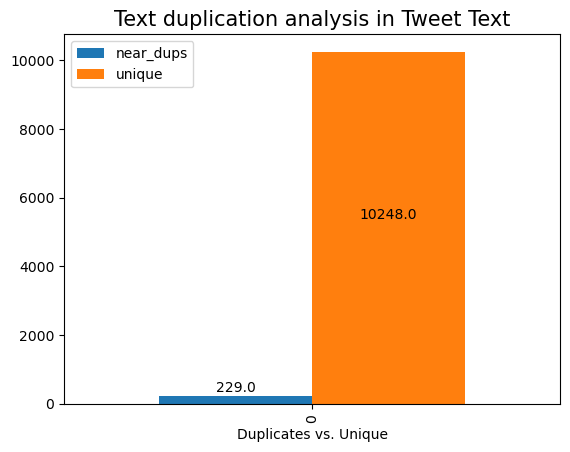

In [23]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Text duplication analysis in Tweet Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [24]:
# Increasing the jaccard distance from 0.3 to 0.5
jaccard_distance = 0.5

df_dups_text_50 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')) 

In [25]:
df_dups_50 = df_dups_text_50
df_dups_text_50.cache()
df_dups_text_50.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.333333,3704,6779,"((@TuckerCarlson Get your kids out of public schools.,),)","((@newsmax Get your kids out of public schools.,),)"
1,0.200000,8633,8751,"((“Dad’s on Duty” is expanding across the states to make a difference in all schools. https://t.co/jwEjrHuTDd,),)","((“Dad’s on Duty” is expanding across the states to make a difference in all schools. https://t.co/IEXYpLy0j1,),)"
2,0.200000,8633,9478,"((“Dad’s on Duty” is expanding across the states to make a difference in all schools. https://t.co/jwEjrHuTDd,),)","((“Dad’s on Duty” is expanding across the states to make a difference in all schools. https://t.co/gK2RmZDstT,),)"
3,0.400000,7698,7764,"((Communicating Commonly Colorado Colleges,),)","((Communicating Colony Colleges Commonly,),)"
4,0.400000,1001,4270,"((@GoodPoliticGuy Public school teachers,),)","((@nathaliejacoby1 Public school teachers,),)"


In [26]:
records = df_hashed_text.count()
dups = df_dups_text_50.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate Tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique Tweets based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10477
Duplicate Tweets based on { 0.5 } jaccard distance:  392
Unique Tweets based on { 0.5 } jaccard distance:  0.5 :  10085


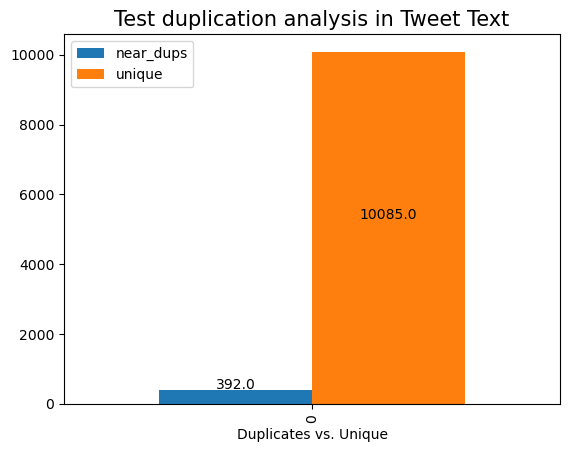

In [27]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Test duplication analysis in Tweet Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [28]:
# Increasing the jaccard distance from 0.5 to 0.7 
jaccard_distance = 0.7

df_dups_title_70 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')) 

In [29]:
df_dups_70 = df_dups_title_70
df_dups_title_70.cache()
df_dups_title_70.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.500000,1098,1124,"((See, public schools.,),)","((@ChayaRaichik10 Public Schools are SO over.,),)"
1,0.666667,1703,5683,"((Disavow public schools,),)","((@laralogan Get your kids out of public schools,),)"
2,0.600000,1703,6617,"((Disavow public schools,),)","((Get your kids out of public schools.,),)"
3,0.600000,2380,4084,"((Why public schools should be shut down.,),)","((Why my kid is not in public schools. https://t.co/wqYUETL3cs,),)"
4,0.666667,5441,9571,"((@awfullystrange @ReviewsPossum Its called public schools.,),)","((Why are our public schools so underfunded 👇,),)"


In [30]:
records = df_hashed_text.count()
dups = df_dups_title_70.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10477
Duplicate titles based on { 0.7 } jaccard distance:  1635
Unique titles based on { 0.7 } jaccard distance:  0.7 :  8842


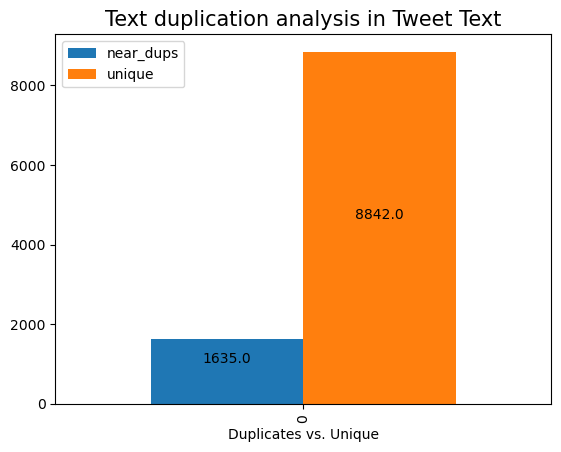

In [31]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Text duplication analysis in Tweet Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Compare thresholds side-by-side

#### Select all pairs of duplicate titles across jaccard similarities

In [32]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

457


819


11111


In [33]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

text_A,text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
{{During BJP's 4 ...,{{During BJP's 4 ...,213,218,213,218,213,218
{{@IAGovernor No ...,{{Money should fo...,1139,7798,null,null,null,null
{{@nytimes @Spiro...,{{Public funding ...,3534,7742,null,null,null,null
{{Public Schools ...,{{Why More Famili...,1594,3947,null,null,null,null
{{Abolish Private...,{{how much is pri...,1108,7063,null,null,null,null


#### Create a Duplicate vs Non-Dup flag for each jaccard similarity

In [34]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5)

text_A,text_B,threshold_30,threshold_50,threshold_70
{{Girl students a...,{{With focus on g...,Non-Dup,Non-Dup,Duplicate
{{Girl students a...,{{With focus on g...,Non-Dup,Non-Dup,Duplicate
{{Communicating C...,{{Communicating C...,Non-Dup,Duplicate,Duplicate
{{@kangaroos991 I...,{{@TheRealHoarse ...,Non-Dup,Non-Dup,Duplicate
{{All parents nee...,{{Schools and par...,Non-Dup,Non-Dup,Duplicate


In [35]:
dups_30_count = df_dups_30_id.count()
dups_50_count = df_dups_50_id.count()
dups_70_count = df_dups_70_id.count()

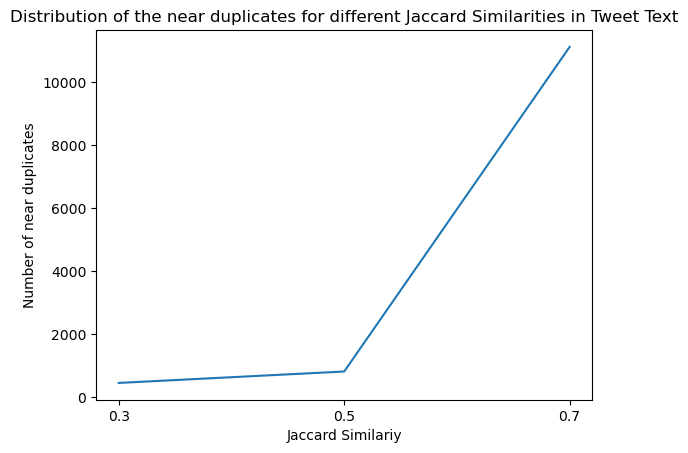

In [36]:
thresholds = [0.3, 0.5, 0.7]
plt.plot(thresholds, [dups_30_count, dups_50_count, dups_70_count])
plt.xlabel('Jaccard Similariy')
plt.ylabel("Number of near duplicates")
plt.xticks([0.3,0.5,0.7])
plt.title("Distribution of the near duplicates for different Jaccard Similarities in Tweet Text")
plt.show()

In [2]:
dups_pd = pd.DataFrame({'dups': [229,392,1635],
                       'uniques': [10248,10085,8842],
                       'threshold':[0.3,0.5,0.7]})

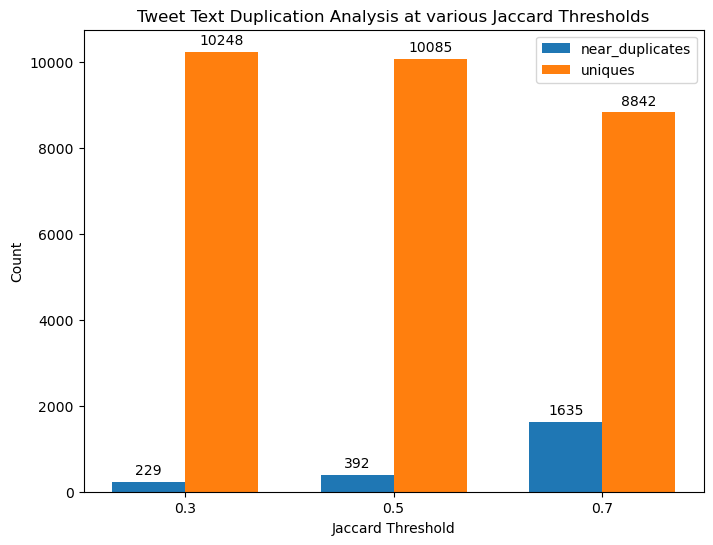

In [7]:
data = dups_pd
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Set up the x-axis and bar widths
x = np.arange(len(data['threshold']))
bar_width = 0.35

# Create the bars for 'dups' and 'uniques'
rects1 = ax.bar(x - bar_width/2, data['dups'], bar_width, label='near_duplicates')
rects2 = ax.bar(x + bar_width/2, data['uniques'], bar_width, label='uniques')

# Set up the x-axis tick labels and title
ax.set_xticks(x)
ax.set_xticklabels(data['threshold'])
ax.set_xlabel('Jaccard Threshold')
ax.set_ylabel('Count')
ax.set_title('Tweet Text Duplication Analysis at various Jaccard Thresholds')

# Add the legend
ax.legend()

# Add labels to the bars
def autolabel(rects):
    """Attach a text label above each bar showing its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

#### Select a sample of records across 3 thresholds (jaccard similarities):
* Records that are marked as duplicate by all three thresholds (meet the level of **threshold_30**)
* Records that are identified as non-duplicate by **threshold_30**, while being marked as dups by both **threshold_50** and **threshold_70**
* Records that are identified as non-duplicate by both **threshold_30** and **threshold_50**, while being marked as dups by **threshold_70**

In [39]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 1313).limit(3).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 1313).limit(3)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 1313).limit(3)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [40]:
pd.set_option('display.max_rows', 30)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"((Schools branded racist for trying to improve pupils' vocabulary | Daily Mail Online https://t.co/RorFWTzXip https://t.co/6fh4ZznggF,),)","((Schools branded racist for trying to improve pupils' vocabulary | Daily Mail Online https://t.co/V3fpAjtHD5,),)",Duplicate,Duplicate,Duplicate
1,"((Let's sue physics professor. https://t.co/YxcbFRkW4W #einstein #relativity #cern #naturephysics #school #anime #NobelPrize,),)","((Let's sue physics professor. https://t.co/YxcbFRkW4W #einstein #relativity #cern #naturephysics #school #anime #NobelPrize,),)",Duplicate,Duplicate,Duplicate
2,"((Take your kids out of public schools now. https://t.co/ZTIKlJV2Aj,),)","((Take your kids out of public schools.,),)",Duplicate,Duplicate,Duplicate
3,"((Get your kids out of federal schools there is nothing public about them,),)","((@laralogan Get your kids out of public schools,),)",Non-Dup,Duplicate,Duplicate
4,"((10 USA graduate schools that don’t require GRE https://t.co/1nqnpJnKkL via @YouTube,),)","((10 USA Graduate Schools that don’t require GRE:\n\nhttps://t.co/ctcSRowHVr,),)",Non-Dup,Duplicate,Duplicate
5,"((@aesthdistance1 Get your children out of public schools,),)","((Sick. Get your children out of public schools.,),)",Non-Dup,Duplicate,Duplicate
6,"((@KCRG Public schools.,),)","((@AlexanderShur Cursive handwriting, not public schools.,),)",Non-Dup,Non-Dup,Duplicate
7,"((No religious schools should receive any public funding. Period.,),)","((Public schools o. Not all,),)",Non-Dup,Non-Dup,Duplicate
8,"((Demons running public schools. Get your kids out before it’s too late.,),)","((All parents need to get their kids out of those schools,),)",Non-Dup,Non-Dup,Duplicate


In [41]:
spark.catalog.clearCache()

#### Visualize message duplication for each entity of Twitterers classified earlier in notebook 4

In [42]:
#Define functions for each operation done above, to make it simpler and run all at once

In [43]:
def get_tokens(df):
    return df\
        .map( lambda document: re.sub(r'[^a-zA-Z0-9 ]', '', document))\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if len(x) >= 2] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()

In [44]:
def to_DF(rdd_, col):    
    row = Row(col)
    return rdd_.map(row).zipWithIndex().toDF([col, 'id'])

def token_cleaning(tokens):
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
    return df_tokens

In [45]:
mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 5)
def get_df_hashed(df_vectorize):
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
    return model, df_hashed

In [46]:
def getJaccardBarChart(df, jaccard_distance, model):

    df_dups_text = model.approxSimilarityJoin(
                        df, df, jaccard_distance
                    ).filter("datasetA.id < datasetB.id").select(
                        col("distCol"),
                        col("datasetA.id").alias("id_A"),
                        col("datasetB.id").alias("id_B"),
                        col("datasetA.tweet_text").alias('text_A'),
                        col("datasetB.tweet_text").alias('text_B')
                    )

    df_dups_text.cache()
    df_dups_text.limit(5).toPandas()
    
    records = df.count()
    dups = df_dups_text.select('id_A').distinct().count()
    uniques = records - dups
    
    clear_output(wait = True)
    
    return df_dups_text, records, dups

In [48]:
StopWords = stopwords.words("english")

def run_similarity(i, fraction_filter, complete = None):
    if(complete == None):
        part_to_analyse = df_tweets_main.filter("entity == '" + i + "'")
        part_to_analyse = part_to_analyse.sample(fraction = fraction_filter, seed = 42)
    else:
        part_to_analyse = df_tweets_main
        part_to_analyse = part_to_analyse.sample(fraction = fraction_filter, seed = 42)
    
    part_to_analyse = part_to_analyse.cache()
    tweets = part_to_analyse.rdd.map(lambda x : x['tweet_text'])

    global StopWords
    text_tokens = get_tokens(tweets)

    df_tweets = to_DF(tweets, 'tweet_text')
    df_tweets_tokens = token_cleaning(text_tokens)

    vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
    df_tweets_tokens_vectorized = vectorize.fit(df_tweets_tokens).transform(df_tweets_tokens)

    model, df_hashed= get_df_hashed(df_tweets_tokens_vectorized)

    df_hashed_text_joined = df_tweets.join(df_hashed, "id", how = 'left')

    df_hashed_text_joined = df_hashed_text_joined.\
                                where(size(df_hashed_text_joined.list_of_words) >= 5)

    text_dups_list = []
    df_dups_text_30, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.3, model)
    text_dups_list.append([records, dups, records - dups, 0.3])

    df_dups_text_40, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.4, model)
    text_dups_list.append([records, dups, records - dups, 0.4])

    df_dups_text_50, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.5, model)
    text_dups_list.append([records, dups, records - dups, 0.5])

    df_dups_text_60, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.6, model)
    text_dups_list.append([records, dups, records - dups, 0.6])

    df_dups_text_70, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.7, model)
    text_dups_list.append([records, dups, records - dups, 0.7])

#     df_ = pd.DataFrame(text_dups_list, columns = ['count', 'dups', 'uniques', 'threshold'])
#     df_.plot(x = 'threshold', y = ['unique','dups'], kind = 'bar', title = i)
#     plt.show()
    return text_dups_list

In [52]:
df_tweets_main = df.select(['tweet_text', 'entity'])

In [50]:
ents = df_tweets_main.groupby('entity').agg(count('*')).toPandas()
display(ents)
entity = list(ents.entity)

,entity,count(1)
0,News and Media,54512
1,Government,7468
2,Influencer,71012
3,Non-Profit,1880
4,Academic,20450
5,Other,364130


In [51]:
print(entity)

['News and Media', 'Government', 'Influencer', 'Non-Profit', 'Academic', 'Other']


In [ ]:
news_sim_list = run_similarity("News and Media", 0.2)
news_df = pd.DataFrame(news_sim_list, columns = ['count', 'dups', 'uniques', 'threshold'])

In [ ]:
govt_sim_list = run_similarity("Government", 1.0)
govt_df = pd.DataFrame(govt_sim_list, columns = ['count', 'dups', 'uniques', 'threshold'])

In [ ]:
inf_sim_list = run_similarity("Influencer", (1/7))
inf_df = pd.DataFrame(inf_sim_list, columns = ['count', 'dups', 'uniques', 'threshold'])

In [64]:
npo_sim_list = run_similarity("Non-Profit", 1.0)
npo_df = pd.DataFrame(npo_sim_list, columns = ['count', 'dups', 'uniques', 'threshold'])

In [ ]:
edu_sim_list = run_similarity("Academic", (10000/20450))
edu_df = pd.DataFrame(edu_sim_list, columns = ['count', 'dups', 'uniques', 'threshold'])

In [ ]:
oth_sim_list = run_similarity("Other", (10000/364130))
oth_df = pd.DataFrame(oth_sim_list, columns = ['count', 'dups', 'uniques', 'threshold'])

In [ ]:
news_df['entity'] = ['News']*5
govt_df['entity'] = ['Government']*5
inf_df['entity'] = ['Influencers']*5
npo_df['entity'] = ['Non-Profit']*5
edu_df['entity'] = ['Academia']*5
oth_df['entity'] = ['Others']*5

ents_df = pd.concat([news_df,govt_df,inf_df,npo_df,edu_df,oth_df], ignore_index = True)

In [129]:
ents_df.to_csv('gs://msca-bdp-students-bucket/shared_data/saikrishnaj/ent_jaccard.csv')

In [130]:
ents_df.head()

,count,dups,uniques,threshold,entity
0,10903,571,10332,0.3,News
1,10903,756,10147,0.4,News
2,10903,940,9963,0.5,News
3,10903,1280,9623,0.6,News
4,10903,2009,8894,0.7,News


In [131]:
ents_df

,count,dups,uniques,threshold,entity
0,10903,571,10332,0.3,News
1,10903,756,10147,0.4,News
2,10903,940,9963,0.5,News
3,10903,1280,9623,0.6,News
4,10903,2009,8894,0.7,News
5,7298,298,7000,0.3,Government
6,7298,392,6906,0.4,Government
7,7298,459,6839,0.5,Government
8,7298,621,6677,0.6,Government
9,7298,1240,6058,0.7,Government


In [6]:
ents_df = pd.read_csv('gs://msca-bdp-students-bucket/shared_data/saikrishnaj/ent_jaccard.csv')
ents_df.drop('Unnamed: 0',axis=1, inplace = True)

In [7]:
ents_df.head()

,count,dups,uniques,threshold,entity
0,10903,571,10332,0.3,News
1,10903,756,10147,0.4,News
2,10903,940,9963,0.5,News
3,10903,1280,9623,0.6,News
4,10903,2009,8894,0.7,News


In [8]:
# Making a pivot table to better visualize the total duplicates at each threshold in each entity
df_pivotx = pd.pivot_table(ents_df, values='dups', index=['entity'], columns=['threshold'], aggfunc=lambda x: x.sum())

# renaming the columns for clarity
df_pivotx.columns = ["Num of Duplicates at Jaccard Threshold: "+str(col*100)+'%' for col in df_pivotx.columns]

# resetting the index
df_pivotx = df_pivotx.reset_index().rename({'entity':'Entity'}, axis=1)

# printing the final dataframe
df_pivotx

,Entity,Num of Duplicates at Jaccard Threshold: 30.0%,Num of Duplicates at Jaccard Threshold: 40.0%,Num of Duplicates at Jaccard Threshold: 50.0%,Num of Duplicates at Jaccard Threshold: 60.0%,Num of Duplicates at Jaccard Threshold: 70.0%
0,Academia,546,819,1014,1264,1852
1,Government,298,392,459,621,1240
2,Influencers,282,352,408,596,1375
3,News,571,756,940,1280,2009
4,Non-Profit,163,179,197,223,276
5,Others,264,316,396,617,1353


In [9]:
# Making a pivot table to better visualize the Percentage of duplicates at each threshold in each entity
df_pivoti = pd.pivot_table(ents_df, values='dups', index='entity', columns='threshold', aggfunc='sum')
df_countx = pd.pivot_table(ents_df, values='count', index='entity', columns='threshold', aggfunc='sum')
df_pivotz = df_pivoti.div(df_countx)

# modify the column names to be in the desired format
df_pivotz.columns = [f'Percentage Duplicates at Jaccard Threshold: {col*100:.1f}%' for col in df_pivotz.columns]

# rename the index column to 'Entity'
df_pivotz.index.name = 'Entity'

# format each value in the dataframe as a percentage
df_pivotz = df_pivotz.applymap(lambda x: '{:.2%}'.format(x))

# print the resulting dataframe
df_pivotz


,Percentage Duplicates at Jaccard Threshold: 30.0%,Percentage Duplicates at Jaccard Threshold: 40.0%,Percentage Duplicates at Jaccard Threshold: 50.0%,Percentage Duplicates at Jaccard Threshold: 60.0%,Percentage Duplicates at Jaccard Threshold: 70.0%
Entity,,,,,
Academia,5.53%,8.29%,10.26%,12.79%,18.74%
Government,4.08%,5.37%,6.29%,8.51%,16.99%
Influencers,2.82%,3.52%,4.08%,5.96%,13.75%
News,5.24%,6.93%,8.62%,11.74%,18.43%
Non-Profit,8.85%,9.72%,10.70%,12.11%,14.99%
Others,2.70%,3.23%,4.05%,6.31%,13.84%


In [10]:
# convert percentage strings to floats
df_pivotz = df_pivotz.applymap(lambda x: float(x.strip('%')) / 100)

# update values in pivot table with converted floats
df_pivotz.values

array([[0.0553, 0.0829, 0.1026, 0.1279, 0.1874],
       [0.0408, 0.0537, 0.0629, 0.0851, 0.1699],
       [0.0282, 0.0352, 0.0408, 0.0596, 0.1375],
       [0.0524, 0.0693, 0.0862, 0.1174, 0.1843],
       [0.0885, 0.0972, 0.107 , 0.1211, 0.1499],
       [0.027 , 0.0323, 0.0405, 0.0631, 0.1384]])

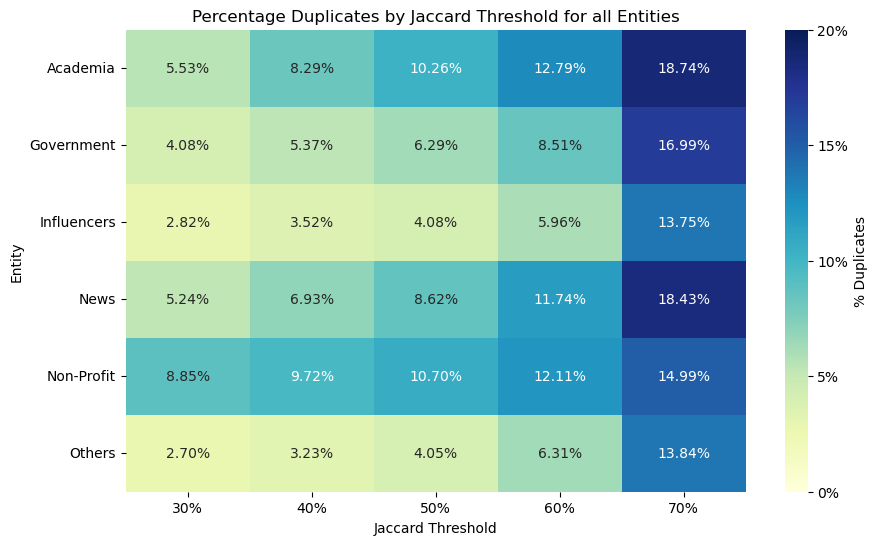

In [59]:
# create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_pivotz, cmap='YlGnBu', annot=True, fmt='.2%', cbar_kws={'format': '%.0f%%', 'ticks': [0, 0.05, 0.10, 0.15, 0.20], 'label': '% Duplicates'}, ax=ax, vmin=0,vmax=0.20)

# customize the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])

# customize the chart
ax.set_xlabel('Jaccard Threshold')
ax.set_ylabel('Entity')
ax.set_title('Percentage Duplicates by Jaccard Threshold for all Entities')

# set new xticks
xticks = [0, 1, 2, 3, 4]
xtick_labels = ['30%', '40%', '50%', '60%', '70%']
ax.set_xticklabels(xtick_labels, rotation=0, ha='center')

plt.show()
